<a href="https://colab.research.google.com/github/sleepsim/Week-2_Data_Preprocessing/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing required libraries (Copied from Week 2 Lab notebook)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import nltk
import librosa

In [3]:
# Get the critical imports out of the way
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
import soundfile
import glob
import os
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')
from IPython.core.display import HTML
# Center matplotlib figures...
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
import librosa

def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    #print(stft_spectrogram.shape)
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    #print(chromagram.shape)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0)
    return mfc_coefficients

def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)
        feature_matrix=np.array([])

        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))

        return feature_matrix

# Cleaning up RAVDESS dataset and storing it into a DataFrame

I expanded on the attributes on the RAVDESS dataset since I'm merging them with the panada dataset, added the other identifiers except modality and vocal channel (since the set we're using only uses Modality = 03, Vocal Channel = 01)

In [5]:
#All attritbutes in the RAVDESS dataset
emotions_RAVDESS ={
  '01':'neutral',
  '02':'calm', # Does not exist in the EMODB databse, dropping if emotion = calm
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised' #Does not exist in the EMODB database, dropping if emotion = surprised
}

# #EMODB Database does not use emotional intensity, this dictionary will not be used
# emotional_intensity = {
#     '01':'normal',
#     '02':'strong'
# }

statement = {
    '01':"Kids are talking by the door",
    '02':"Dogs are sitting by the door"
}

repetition = {
    '01':"1st",
    '02':"2nd"
}

Main data cleaning, the function outputs a dataframe with cleaned data, comments explain how cleaning works

In [6]:
from sys import intern
#Getting the data from the RAVDESS dataset
def get_RAVDESS_df():
    count = 0
    out_list = []

    for file in glob.glob("/content/drive/MyDrive/IAT481/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
        # This will hold all of the information
        metadata = []
        file_name = os.path.basename(file)

        # Grab information and store it in order of, Actor -> Emotion -> Emotional Intensity -> Statement -> Repetition
        metadata.append("Actor (RAVDESS) " + (file_name.split("-")[6]).split(".")[0]) #Actor number
        actorNum =  (file_name.split("-")[6]).split(".")[0]
        if (int(actorNum) % 2) == 0:
            metadata.append("female")
        else:
            metadata.append("male")

        if (emotions_RAVDESS[file_name.split("-")[2]] == ("calm") or emotions_RAVDESS[file_name.split("-")[2]] == ("surprised")):
            continue
        else:
            metadata.append(emotions_RAVDESS[file_name.split("-")[2]]) #Emotion

        metadata.append(statement[file_name.split("-")[4]])
        metadata.append(repetition[file_name.split("-")[5]])
        out_list.append((metadata))
        count += 1

    labels = ['Actor', 'Gender','Emotion', 'Statement', 'Repetition']
    ravdess_df = pd.DataFrame.from_records(out_list, columns = labels)

    return ravdess_df

To make a plot later to compare emotions, we'll make a function to grab all the emotions in the dataset

In [7]:
def get_RAVDESS_emotionCount():
    emotionCount_holder = []

    #Add the emotion to the list that gets outputted
    for file in glob.glob("/content/drive/MyDrive/IAT481/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
        file_name = os.path.basename(file)
        if (emotions_RAVDESS[file_name.split("-")[2]] == ("calm") or emotions_RAVDESS[file_name.split("-")[2]] == ("surprised")):
            continue
        else:
            emotionCount_holder.append(emotions_RAVDESS[file_name.split("-")[2]])

    return emotionCount_holder

Test our dataframe

In [8]:
ravdessDataframe = get_RAVDESS_df()
ravdessDataframe

,Actor,Gender,Emotion,Statement,Repetition
0,Actor (RAVDESS) 10,female,neutral,Dogs are sitting by the door,2nd
1,Actor (RAVDESS) 10,female,neutral,Dogs are sitting by the door,1st
2,Actor (RAVDESS) 10,female,neutral,Kids are talking by the door,1st
3,Actor (RAVDESS) 10,female,neutral,Kids are talking by the door,2nd
4,Actor (RAVDESS) 10,female,angry,Kids are talking by the door,2nd
...,...,...,...,...,...
1049,Actor (RAVDESS) 21,male,disgust,Dogs are sitting by the door,1st
1050,Actor (RAVDESS) 21,male,disgust,Dogs are sitting by the door,2nd
1051,Actor (RAVDESS) 21,male,fearful,Kids are talking by the door,2nd
1052,Actor (RAVDESS) 21,male,disgust,Kids are talking by the door,1st


Check if we have even number of items in every column, looks good

In [9]:
ravdessDataframe.count()

Actor         1054
Gender        1054
Emotion       1054
Statement     1054
Repetition    1054
dtype: int64

More checking to see unique values, and top occuring values

In [10]:
ravdessDataframe.describe(include="all")

,Actor,Gender,Emotion,Statement,Repetition
count,1054,1054,1054,1054,1054
unique,24,2,6,2,2
top,Actor (RAVDESS) 10,male,angry,Dogs are sitting by the door,2nd
freq,44,528,192,527,527


Check if the data has been filtered properly, should not contain surprised/calm

In [11]:
ravdessDataframe['Emotion'].unique()

array(['neutral', 'angry', 'happy', 'sad', 'disgust', 'fearful'],
      dtype=object)

**Let's plot all the emotions**

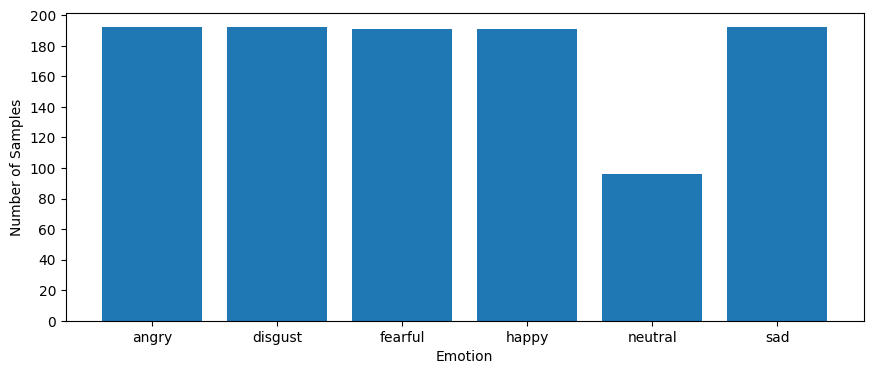

In [12]:
RAVDESS_emotionCount = get_RAVDESS_emotionCount()

#plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(RAVDESS_emotionCount, return_counts=True)
plt.bar(x=range(6), height=count)
plt.xticks(ticks=range(6), labels = [emotion for emotion in emotion_list],fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=10)
plt.yticks(np.arange(0, 220, 20))
plt.ylabel('Number of Samples')
plt.show()

**Let's plot the genders**

In [13]:
ravdessDataframe['Gender'].value_counts() #this returns the amount of each unique value in list form

male      528
female    526
Name: Gender, dtype: int64

In [14]:
ravdessDataframe['Gender'].value_counts().keys().tolist() #this returns all unique values in the column gender list form

['male', 'female']

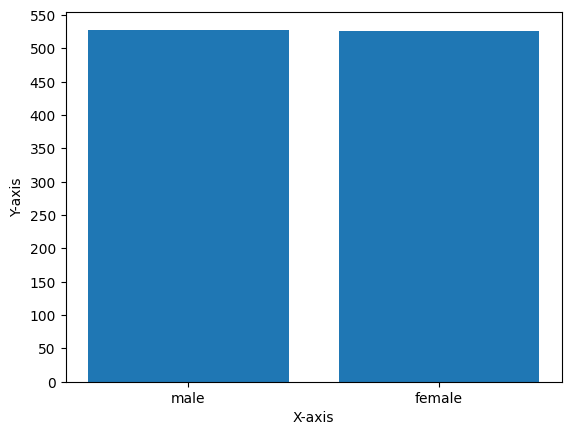

In [15]:
# Assign values x = genders, y = number of
valx = ravdessDataframe['Gender'].value_counts().keys().tolist() #this returns all unique values in the column gender list form
valy = ravdessDataframe['Gender'].value_counts().tolist() #this returns the amount of each unique value in list form

plt.bar(valx, valy)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.yticks(np.arange(0, 600, 50))
plt.show()

**POSSIBLE IMPACTS**

From what I can see, the emotions and the genders have almost near identical even distribution. The difference in a dataset this size should be negligible. The only possible cause of concern is that "neutral" has almost half the amount as the other emotions. Otherwise, I think this dataset is well balanced

# Cleaning up EMODB dataset and storing it into a DataFrame

To clean up the EMODB database, I changed some of the naming schemes to match that of the RAVDESS database, as well as rename their "speakers" into "Actors". Additionally, I renamed versions -> repetitions

In [16]:
#For reminding myself how the naming syntax works

filename_syntax = "03a01Nc.wav"
print(filename_syntax[:2]) #Speaker
print(filename_syntax[2:5]) #Text Code
print(filename_syntax[5:6]) #Emotion
print(filename_syntax[6:7]) #Version

03
a01
N
c


EMODB used different names for their emotions like "happiness" instead of "happy". For these cases, I simply changed it to match the RAVDESS DB.

In [17]:
#All attributes of EMODB Data

emotions_EMODB = {
    'N':'neutral',
    'W':'angry', #ORIGINALLY "anger"
    'L':'boredom', #Does not exist in the RAVDESS database, dropping file if emotion = boredom
    'E':'disgust',
    'A':'fearful', #ORIGINALLY "anxiety/fear"
    'F':'happy', #ORIGINALLY "happiness"
    'T':'sad' #ORIGINALLY "sadness"
}

# speakers_EMODB = {
#     '03':'Actor (EMODB)',
#     '08':'Actor (EMODB)',
#     '09':'Actor (EMODB)',
#     '10':'Actor (EMODB)',
#     '11':'Actor (EMODB)',
#     '12':'Actor (EMODB)',
#     '13':'Actor (EMODB)',
#     '14':'Actor (EMODB)',
#     '15':'- male 25y',
#     '16':'- female 31y',
# }

genders_EMODB = {
    '03':'male',
    '08':'female',
    '09':'female',
    '10':'male',
    '11':'male',
    '12':'male',
    '13':'female',
    '14':'female',
    '15':'male',
    '16':'female',
}

rep_EMODB = {
    'a': "1st",
    'b': "2nd",
    'c': "3rd",
    'd': "4th",
    'e':"5th",
    'f':"6th"
}

Main cleanup, comments on the code explain how cleaning took place

In [18]:
#Getting the data from the RAVDESS dataset
def get_EMODB_df():
    count = 0
    out_list = []

    for file in glob.glob("/content/drive/MyDrive/IAT481/EMODB/*.wav"):
        # This will hold all of the information
        metadata = []
        file_name = os.path.basename(file)

        #Grab information and store it in order Speaker -> Emotion -> Text Code -> Version. It's done this way to match ordering of RAVDESS
        metadata.append("Actor (EMODB) " + file_name[:2]) # Actor
        metadata.append(genders_EMODB[file_name[:2]]) # Gender
        if emotions_EMODB[file_name[5:6]] == "boredom":
            continue
        else:
            metadata.append(emotions_EMODB[file_name[5:6]]) # Emotion
        metadata.append(file_name[2:5]) #Text code
        metadata.append(rep_EMODB[file_name[6:7]]) # Repetition

        #Store in the array as a tuple
        out_list.append((metadata))
        count += 1

    #Construct dataframe using the labels and list
    labels = ['Actor', 'Gender', 'Emotion', 'Statement', 'Repetition']
    emodb_df = pd.DataFrame.from_records(out_list, columns = labels)

    return emodb_df

In [19]:
def get_EMODB_emotionCount():
    emotionCount_holder = []

    #Add the emotion to the list that gets outputted
    for file in glob.glob("/content/drive/MyDrive/IAT481/EMODB/*.wav"):
        file_name = os.path.basename(file)
        if emotions_EMODB[file_name[5:6]] == "boredom":
            continue
        else:
            emotionCount_holder.append(emotions_EMODB[file_name[5:6]])

    return emotionCount_holder

Let's test the dataframe

In [20]:
emodbDataframe = get_EMODB_df()
emodbDataframe

,Actor,Gender,Emotion,Statement,Repetition
0,Actor (EMODB) 03,male,happy,a02,3rd
1,Actor (EMODB) 03,male,happy,a01,1st
2,Actor (EMODB) 03,male,neutral,a02,3rd
3,Actor (EMODB) 03,male,neutral,a01,3rd
4,Actor (EMODB) 03,male,angry,a02,2nd
...,...,...,...,...,...
449,Actor (EMODB) 15,male,angry,a05,1st
450,Actor (EMODB) 15,male,happy,a01,2nd
451,Actor (EMODB) 16,female,sad,a01,2nd
452,Actor (EMODB) 15,male,angry,b03,1st


Checking to see if there's any null or missing items in the dataset, looks good

In [21]:
ravdessDataframe.count()

Actor         1054
Gender        1054
Emotion       1054
Statement     1054
Repetition    1054
dtype: int64

Like the RAVDESS dataset, check to see how many unique values per, and the top occuring ones

In [22]:
emodbDataframe.describe(include="all")

,Actor,Gender,Emotion,Statement,Repetition
count,454,454,454,454,454
unique,10,2,6,10,6
top,Actor (EMODB) 14,female,angry,a05,1st
freq,61,256,127,53,143


Check to see if boredom has been filtered out properly

In [23]:
emodbDataframe['Emotion'].unique()

array(['happy', 'neutral', 'angry', 'sad', 'fearful', 'disgust'],
      dtype=object)

**Let's plot emotions**

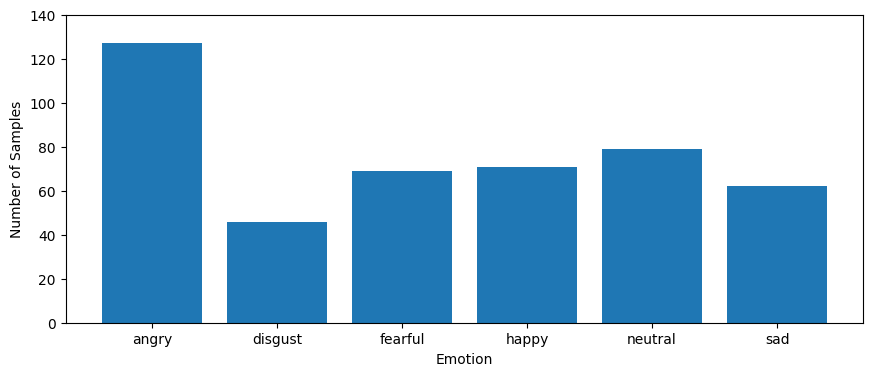

In [24]:
EMODB_emotionCount = get_EMODB_emotionCount()

#plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(EMODB_emotionCount, return_counts=True)
plt.bar(x=range(6), height=count)
plt.xticks(ticks=range(6), labels = [emotion for emotion in emotion_list],fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=10)
plt.yticks(np.arange(0, 160, 20))
plt.ylabel('Number of Samples')
plt.show()

**Let's plot genders**
same format for how I did the ravdess database

In [25]:
emodbDataframe['Gender'].value_counts().tolist() #this returns all unique values in the column gender list form

[256, 198]

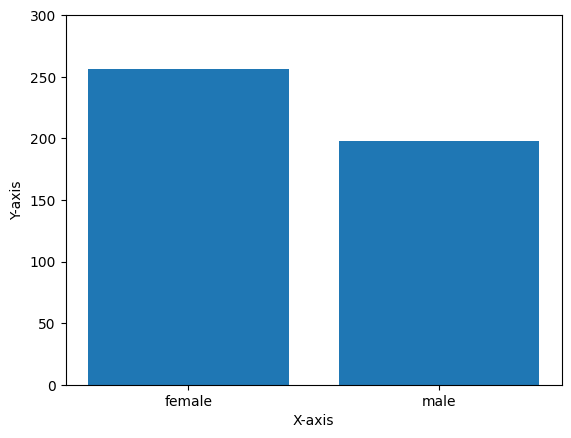

In [26]:
# Assign values x = genders, y = number of
valx = emodbDataframe['Gender'].value_counts().keys().tolist() #this returns all unique values in the column gender list form
valy = emodbDataframe['Gender'].value_counts().tolist() #this returns the amount of each unique value in list form

plt.bar(valx, valy)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.yticks(np.arange(0, 350, 50))
plt.show()

Unlike the RAVDESS dataset, the EMODB dataset seems unbalanced. There's more angry than any other emotion by quite a large margin. There's also an imbalance with gender for this dataset, = more female datapoints

# Comparing Features (RAVDESS VS EMODB)

I'm not going to pretend to know how to interpret Short-Time Fourier Transform but for comparison, I will be using a [ANGRY][MALE] voice clip from RAVDESS vs a [ANGRY][MALE] voice clip from EMODB

RAVDESS = 03-01-05-01-01-01-13.wav -> Angry Male Actor 13

EMODB = 03a01Wa -> Angry Male 31yo Actor 03

In [77]:
with soundfile.SoundFile('/content/drive/MyDrive/IAT481/Audio_Speech_Actors_01-24/Actor_13/03-01-05-01-01-01-13.wav') as audio:

    RAVDESS_angry_waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate

with soundfile.SoundFile('/content/drive/MyDrive/IAT481/EMODB/03a01Wa.wav') as audio:
    EMODB_angry_waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate

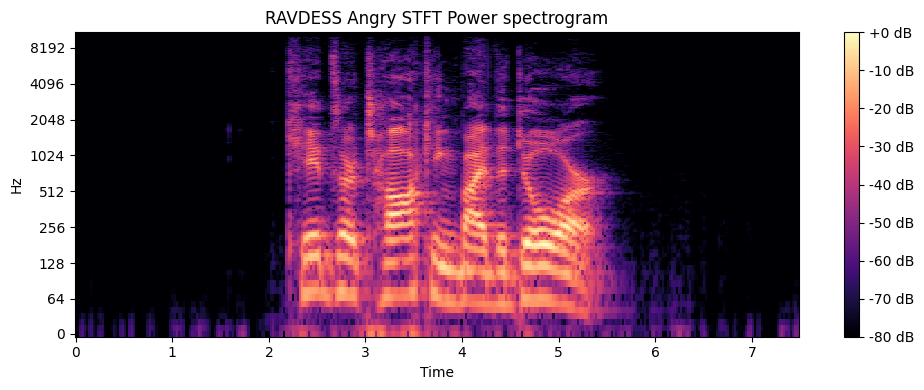

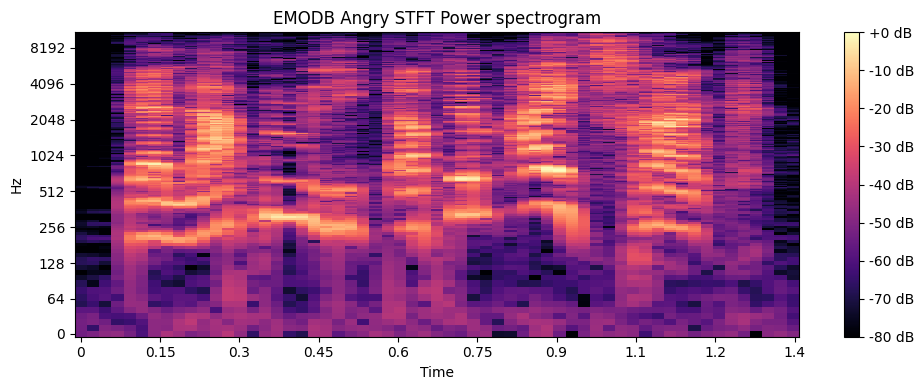

In [78]:
stft_spectrum_matrix = librosa.stft(RAVDESS_angry_waveform)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('RAVDESS Angry STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

stft_spectrum_matrix = librosa.stft(EMODB_angry_waveform)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
plt.title('EMODB Angry STFT Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

Now for the MFC

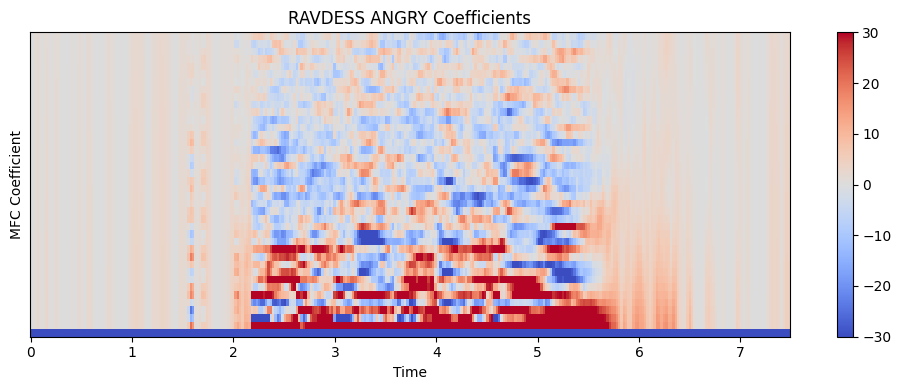

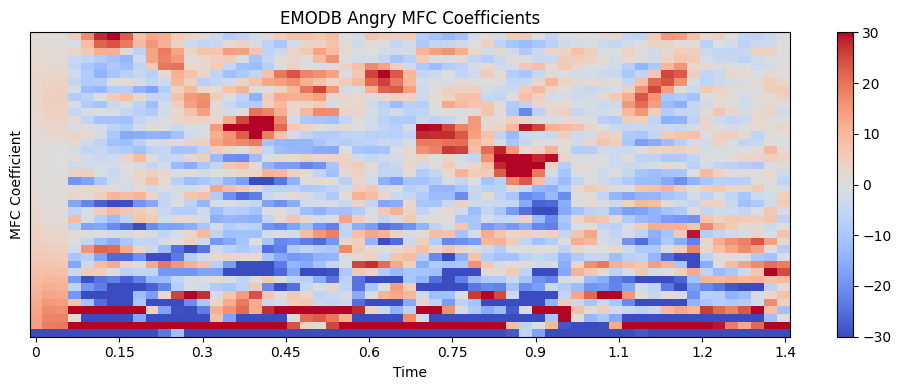

In [83]:
from matplotlib.colors import Normalize
mfc_coefficients = librosa.feature.mfcc(y=RAVDESS_angry_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(())
plt.ylabel('MFC Coefficient')
plt.title('RAVDESS ANGRY Coefficients')
plt.tight_layout()

mfc_coefficients = librosa.feature.mfcc(y=EMODB_angry_waveform, sr=sample_rate, n_mfcc=40)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfc_coefficients, x_axis='time',norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.yticks(())
plt.ylabel('MFC Coefficient')
plt.title('EMODB Angry MFC Coefficients')
plt.tight_layout()

MEL Spectrogram

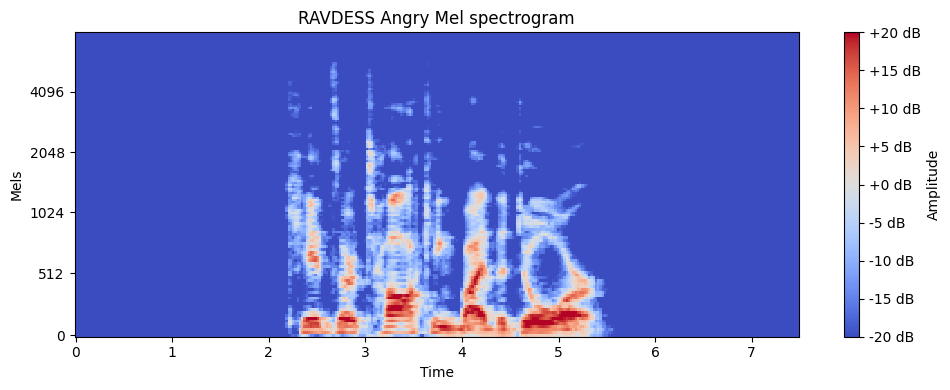

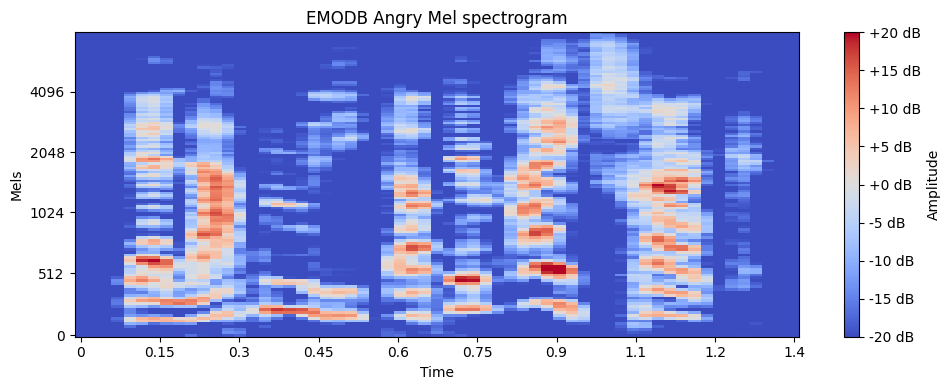

In [86]:
melspectrogram = librosa.feature.melspectrogram(y=RAVDESS_angry_waveform, sr=sample_rate, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.mean),y_axis='mel',fmax=8000, x_axis='time', norm=Normalize(vmin=-20,vmax=20))
plt.colorbar(format='%+2.0f dB',label='Amplitude')
plt.ylabel('Mels')
plt.title('RAVDESS Angry Mel spectrogram')
plt.tight_layout()

melspectrogram = librosa.feature.melspectrogram(y=EMODB_angry_waveform, sr=sample_rate, n_mels=128, fmax=8000)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.mean),y_axis='mel',fmax=8000, x_axis='time', norm=Normalize(vmin=-20,vmax=20))
plt.colorbar(format='%+2.0f dB',label='Amplitude')
plt.ylabel('Mels')
plt.title('EMODB Angry Mel spectrogram')
plt.tight_layout()

Last but not the least chromagram

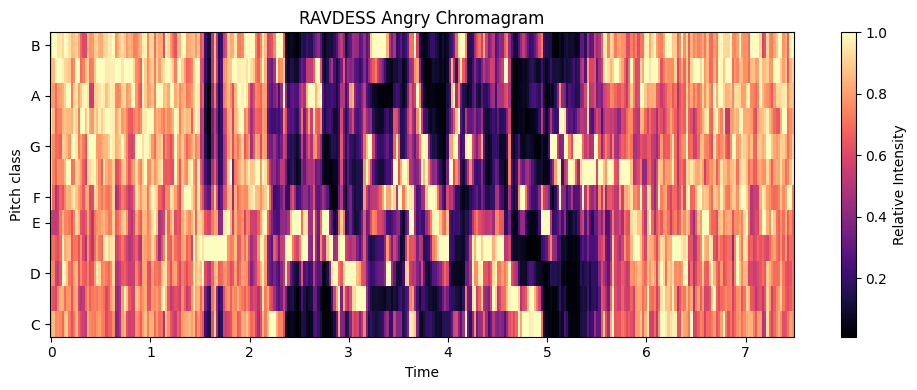

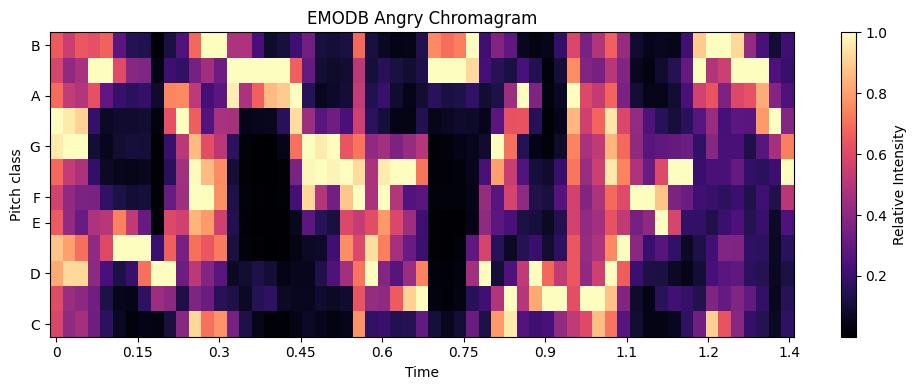

In [88]:
chromagram = librosa.feature.chroma_stft(y=RAVDESS_angry_waveform, sr=sample_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.title('RAVDESS Angry Chromagram')
plt.tight_layout()

chromagram = librosa.feature.chroma_stft(y=EMODB_angry_waveform, sr=sample_rate)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.title('EMODB Angry Chromagram')
plt.tight_layout()

There's a weird issue with the scaling because the RAVDESS clips are around 7~ seconds whereas the EMODB clips are 1.4~s

There's also some differences on how the visualizations look which I think might be due to language differences?

# Combined Datasets

To combine the dataset, I used panda.concat and ignored the indexes and no sorting. Our original datasets had 1054 + 453 = 1507, which meanas the combination was successful.

In [27]:
combinedDataframe = pd.concat([ravdessDataframe, emodbDataframe], ignore_index=True, sort=False)
combinedDataframe

,Actor,Gender,Emotion,Statement,Repetition
0,Actor (RAVDESS) 10,female,neutral,Dogs are sitting by the door,2nd
1,Actor (RAVDESS) 10,female,neutral,Dogs are sitting by the door,1st
2,Actor (RAVDESS) 10,female,neutral,Kids are talking by the door,1st
3,Actor (RAVDESS) 10,female,neutral,Kids are talking by the door,2nd
4,Actor (RAVDESS) 10,female,angry,Kids are talking by the door,2nd
...,...,...,...,...,...
1503,Actor (EMODB) 15,male,angry,a05,1st
1504,Actor (EMODB) 15,male,happy,a01,2nd
1505,Actor (EMODB) 16,female,sad,a01,2nd
1506,Actor (EMODB) 15,male,angry,b03,1st


Check for NULL values, all values are same so seems to be good

In [28]:
combinedDataframe.count()

Actor         1508
Gender        1508
Emotion       1508
Statement     1508
Repetition    1508
dtype: int64

To be safe, let's check the unique values for each of the columns, there's still only 6, and they're correct YAY

In [29]:
combinedDataframe['Emotion'].unique()

array(['neutral', 'angry', 'happy', 'sad', 'disgust', 'fearful'],
      dtype=object)

Last check just to make sure, still looks good so gonna keep this

In [30]:
combinedDataframe.describe(include="all")

,Actor,Gender,Emotion,Statement,Repetition
count,1508,1508,1508,1508,1508
unique,34,2,6,12,6
top,Actor (EMODB) 14,female,angry,Dogs are sitting by the door,1st
freq,61,782,319,527,670


In [31]:
combinedDataframe['Emotion'].value_counts()

angry      319
happy      262
fearful    260
sad        254
disgust    238
neutral    175
Name: Emotion, dtype: int64

In [32]:
combinedDataframe['Emotion'].value_counts().keys().tolist()

['angry', 'happy', 'fearful', 'sad', 'disgust', 'neutral']

In [33]:
combinedDataframe['Emotion'].value_counts().tolist()

[319, 262, 260, 254, 238, 175]

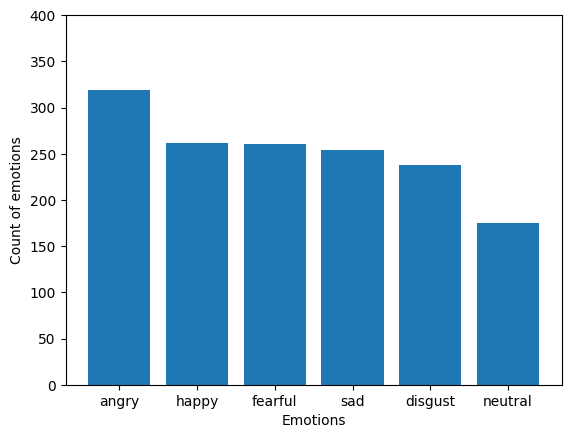

In [34]:
# Assign values x = genders, y = number of
valx = combinedDataframe['Emotion'].value_counts().keys().tolist()
valy = combinedDataframe['Emotion'].value_counts().tolist()

plt.bar(valx, valy)
plt.xlabel('Emotions')
plt.ylabel('Count of emotions')

plt.yticks(np.arange(0, 450, 50))
plt.show()

In [35]:
combinedDataframe['Gender'].value_counts()

female    782
male      726
Name: Gender, dtype: int64

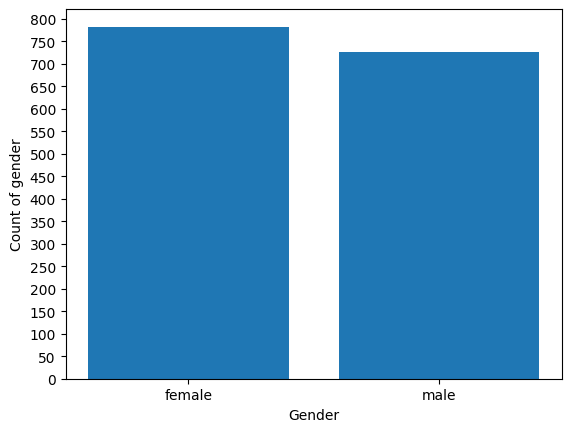

In [36]:
# Assign values x = genders, y = number of
valx = combinedDataframe['Gender'].value_counts().keys().tolist()
valy = combinedDataframe['Gender'].value_counts().tolist()

plt.bar(valx, valy)
plt.xlabel('Gender')
plt.ylabel('Count of gender')

plt.yticks(np.arange(0, 850, 50))
plt.show()

# Comparing Features

I'm running features in a separate section code block because it's very laggy especially in google collab and I didn't want to have to wait 10 minutes everytime I wanted to load and test the notebook

In [61]:
def load_features_COMBINED():
    X=[]
    count = 0

    # RAVDESS
    for file in glob.glob("/content/drive/MyDrive/IAT481/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        if(emotions_RAVDESS[file_name.split("-")[2]] == ("calm") or emotions_RAVDESS[file_name.split("-")[2]] == ("surprised")):
            continue
        else:
            features = get_features(file)
            X.append(features)
            count += 1
            # '\r' + end='' results in printing over same line
            print('\r' + f' Processed {count}/{1508} audio samples',end=' ')

    # EMODB
    for file in glob.glob("/content/drive/MyDrive/IAT481/EMODB/*.wav"):
        file_name = os.path.basename(file)
        if emotions_EMODB[file_name[5:6]] == "boredom":
            continue
        else:
            features = get_features(file)
            X.append(features)
            count += 1
            print('\r' + f' Processed {count}/{1508} audio samples',end=' ')

    return np.array(X)

In [62]:
featuresCOMBINED = load_features_COMBINED() # THIS PROCESSING TAKES 10 YEARS

 Processed 1508/1508 audio samples 

In [63]:
featuresCOMBINED

array([[ 0.61746645,  0.576461  ,  0.5690396 , ...,  2.2545314 ,
        -0.19808407,  4.3439054 ],
       [ 0.62391883,  0.5744877 ,  0.5174031 , ...,  4.9281864 ,
         3.682733  ,  4.037534  ],
       [ 0.67782056,  0.6169823 ,  0.6157824 , ...,  2.148702  ,
         1.1802734 ,  4.521074  ],
       ...,
       [ 0.47335088,  0.4839603 ,  0.51272964, ...,  2.0139842 ,
        -0.79198027,  1.1624281 ],
       [ 0.5457111 ,  0.5716306 ,  0.56832665, ...,  1.2896541 ,
        -1.3830453 ,  0.65675086],
       [ 0.433717  ,  0.44542938,  0.50270736, ...,  6.4208884 ,
         5.7319336 ,  5.495753  ]], dtype=float32)

In [65]:
print(f'\nAudio samples represented: {featuresCOMBINED.shape[0]}')
print(f'Numerical features extracted per sample: {featuresCOMBINED.shape[1]}')
features_df = pd.DataFrame(featuresCOMBINED) # make it pretty for display
features_df


Audio samples represented: 1508
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.617466,0.576461,0.569040,0.609814,0.654684,0.701384,0.735561,0.717063,0.728129,0.702318,...,-3.581316,-0.467617,-3.222230,0.313375,3.955157,-0.183977,1.367951,2.254531,-0.198084,4.343905
1,0.623919,0.574488,0.517403,0.513132,0.550291,0.568414,0.568268,0.579836,0.644346,0.689928,...,1.126486,3.953426,1.156003,6.056956,5.954752,3.322112,6.695466,4.928186,3.682733,4.037534
2,0.677821,0.616982,0.615782,0.621085,0.626168,0.646080,0.691546,0.685554,0.722938,0.696742,...,-1.149269,1.404988,-1.316433,3.550398,3.366586,0.352723,2.582228,2.148702,1.180273,4.521074
3,0.541733,0.565394,0.591974,0.606679,0.647344,0.677179,0.715182,0.705764,0.707652,0.667793,...,-2.528749,0.933915,-4.214124,1.486633,3.447144,0.343212,1.673163,1.149167,-1.704414,2.925104
4,0.473540,0.471911,0.494642,0.486543,0.527230,0.642038,0.701873,0.645157,0.621900,0.605100,...,1.344774,-0.028760,0.591915,0.167358,1.744662,-1.228223,-0.578519,0.850627,-1.625405,0.764073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.630614,0.560570,0.558813,0.602351,0.594018,0.579525,0.582606,0.596068,0.596626,0.575346,...,1.270977,2.942889,1.924995,-0.258538,1.442230,2.028683,2.920096,0.801694,-0.214500,2.016133
1504,0.542363,0.524387,0.578678,0.658869,0.734859,0.719763,0.700182,0.692838,0.611206,0.587929,...,4.536748,4.841665,4.016246,4.389596,3.703093,2.252395,0.193578,2.083185,2.247706,0.556803
1505,0.473351,0.483960,0.512730,0.557046,0.618221,0.654557,0.741644,0.795936,0.727333,0.622922,...,9.805486,9.686046,5.774399,6.234601,4.742285,4.019741,2.513649,2.013984,-0.791980,1.162428
1506,0.545711,0.571631,0.568327,0.623234,0.643241,0.600672,0.594900,0.592985,0.621128,0.626903,...,1.421952,2.146757,3.173037,5.039952,3.672264,2.315314,0.728596,1.289654,-1.383045,0.656751


**Feature Scaling**

In [66]:
# We would usually use df.describe(), but it provides a bit of a mess of information we don't need at the moment.
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:,:11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}')

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:,12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.loc[:,140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')

print_features(features_df)

12 Chromagram features:           min = 0.276,     max = 0.888,     mean = 0.640,     deviation = 0.093

128 Mel Spectrogram features:     min = 0.000,     max = 886.647,     mean = 1.328,     deviation = 9.748

40 MFCC features:                 min = -863.639,    max = 121.174,    mean = -11.163,    deviation = 82.575


Like the lab example, there's an imbalance and a big deviation for the **MEL Spectrogram** and the **MFC features** specially. I don't fully understand how the features really work or what they mean but as explained in the original Week 2 file, we have to lessen the deviation. I copied the code given to us

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = featuresCOMBINED
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = featuresCOMBINED
features_minmax = scaler.fit_transform(features_minmax)

In [71]:
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print('\n\n\033[1m'+'MinMax Scaling:\n'+'\033[0m')
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

Standard Scaling:

12 Chromagram features:           min = -4.046,     max = 2.602,     mean = -0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.475,     max = 33.092,     mean = 0.000,     deviation = 1.000

40 MFCC features:                 min = -4.719,    max = 6.582,    mean = -0.000,    deviation = 1.000


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.599,     deviation = 0.179

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.024,     deviation = 0.068

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.393,    deviation = 0.177


AND IT WORKS!!!!!!!!!!! I still dont understand how to read chromagrams or MEL Spectrograms and MFCCs but the deviation is now 1 or 0.1 which means we can now use it for models???